# (04) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 2
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:2  ———  host: mach

## CIFAR10:

- MLP decoder
- $(T, \beta) = (32, 12.0)$

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('CIFAR10', model_type, 'jacob|conv')

seq_len = 8
cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 10/8 * seq_len
cfg_tr['lr'] = 5e-4

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [5]:
tr.n_iters

125000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  2.3 Mil   |
|     ———     |    ———     |
|    layer    |  2.3 Mil   |
+-------------+------------+

poisson_CIFAR10_t-8_z-[1024]_k-32_<jacob|conv>
b100-ep250-lr(0.0005)_beta(10:0x0.1)_temp(0.05:lin-0.5)_gr(2000)_(2024_09_16,10:06)

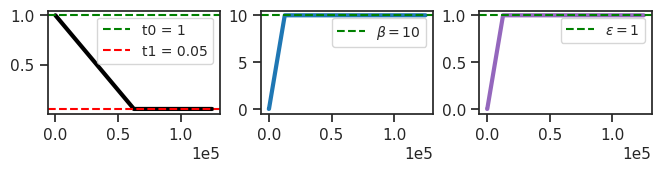

In [6]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [7]:
tr.n_iters

125000

In [8]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  2.3 Mil   |
|     ———      |    ———     |
|    fc_dec    |  1.1 Mil   |
|     dec      |  1.2 Mil   |
+--------------+------------+

In [9]:
print(tr.model.layer.dec)

Sequential(
  (0): UnFlatten()
  (1): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=256, out_features=16, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=16, out_features=256, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (2): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(
        (_layer): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (3): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (4): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(
        (_layer): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (5): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (6): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(
        (_layer): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=32, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (7): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(
          (_layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_f

### Fit model

In [ ]:
tr.train()

epoch # 6, avg loss: 258.589083:   2%|▏     | 6/250 [16:39<11:06:24, 163.87s/it]

In [ ]:
print(tr.model.layer.n_exp)

In [ ]:
plt.plot(vae.stats['du_max'])

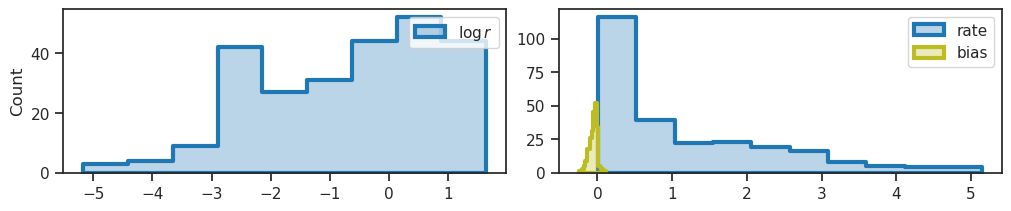

In [13]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [14]:
dead = log_rate < -7
dead.sum()

0

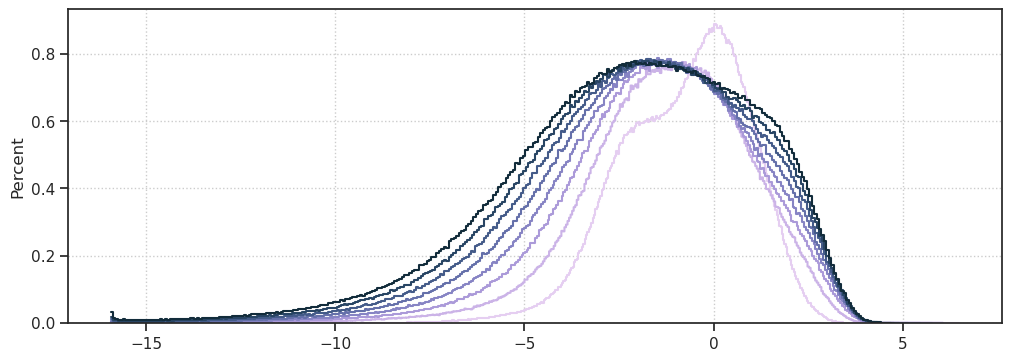

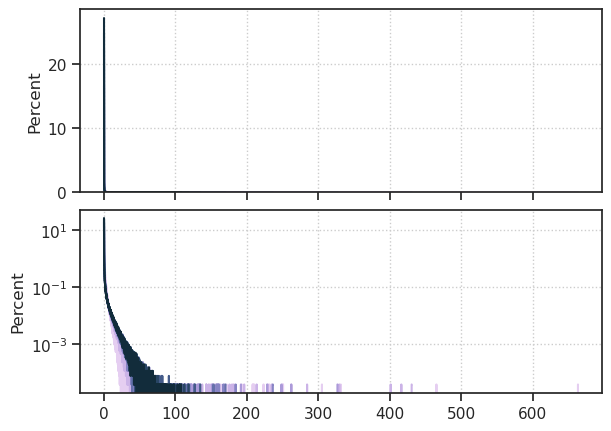

In [16]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v[:, ~dead].ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [17]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.79560472689218, 0.7025635211553574, 0.906794768375293],
 [0.6686407796183966, 0.6049991340541501, 0.8494437689559234],
 [0.5300158317387482, 0.5177020247219766, 0.7688253061707515],
 [0.3958415626832449, 0.4388270462167934, 0.6665458619228831],
 [0.26577992459661565, 0.3565507347057864, 0.5356429755155622],
 [0.158519102797742, 0.271866265196377, 0.39112323360373646],
 [0.07235872150128392, 0.17287618251766537, 0.23013648857700542]]

In [3]:
tr, meta = load_model(
    'poisson_CIFAR10_t-8_z-[256]_k-32_<jacob|conv>',
    'b200-ep480-lr(0.002)_beta(4:0x0.1)_temp(0.05:lin-0.5)_gr(500)_(2024_09_15,21:34)',
    device=device,
)

100%|█████████████████████████████████| 50/50 [17:56<00:00, 21.53s/it]


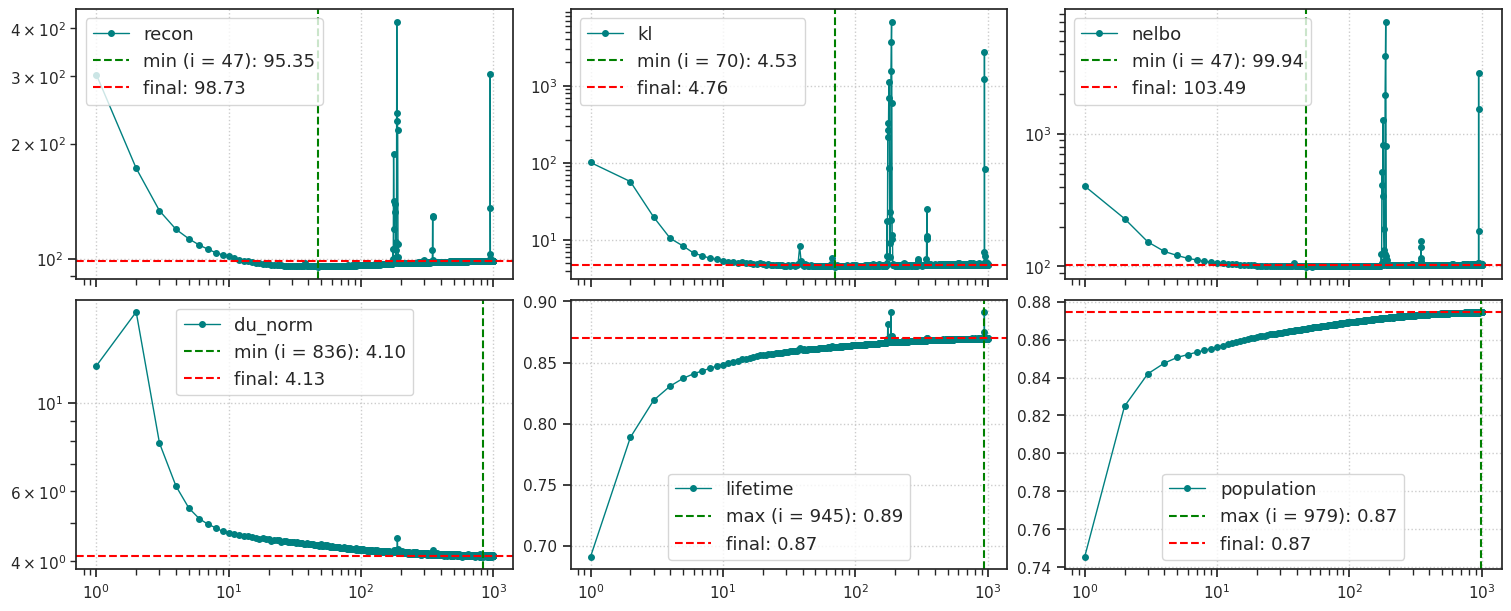

CPU times: user 17min 47s, sys: 8.04 s, total: 17min 55s
Wall time: 18min 1s


In [6]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=100,
    n_data_batches=None,
    # active=~dead,
)
results = tr.analysis(dl='vld', **kws)
_ = plot_convergence(results, color='teal')

In [16]:
%%time

kws = dict(
    seq_total=tr.model.cfg.seq_len,
    seq_batch_sz=100,
    n_data_batches=1,
    # active=~dead,
    return_recon=True,
    full_data=True,
    verbose=False,
)
results_to_plot = {
    name: tr.analysis(dl=name, **kws)
    for name in ['trn', 'vld']
}

CPU times: user 13.6 s, sys: 690 ms, total: 14.3 s
Wall time: 337 ms


In [44]:
num = 32

x2p_dict = {}
for name, d in results_to_plot.items():
    x2p = np.concatenate([
        d['x'][:num],
        d['y'][:num, -1].reshape(-1, *tr.model.cfg.input_sz),
    ])
    x2p = (x2p + 1) / 2
    x2p = np.clip(x2p, 0, 1)
    x2p_dict[name] = x2p
    # _ = plot_weights(x2p, nrows=2)

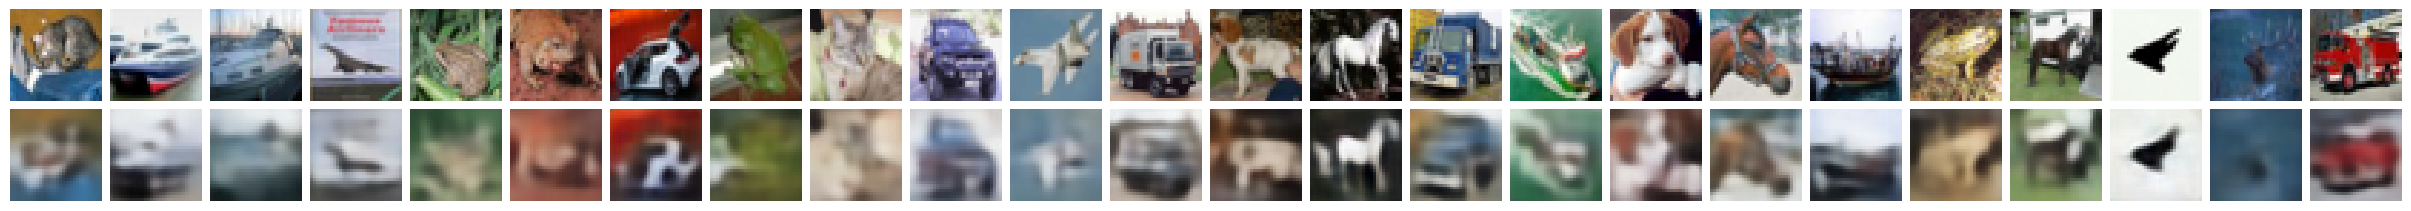

In [47]:
name = 'vld'

fig, axes = create_figure(2, 24, (24, 2))
for i in range(24):
    axes[0, i].imshow(x2p_dict[name][i].transpose(1, 2, 0))
    axes[1, i].imshow(x2p_dict[name][i + 32].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

## EMNIST:

- Linear decoder
- $(T, \beta) = (32, 12.0)$

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('EMNIST', model_type, 'jacob|lin')

seq_len = 32
cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 3/8 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  402.4 K   |
|     ———     |    ———     |
|    layer    |  402.4 K   |
+-------------+------------+

poisson_EMNIST_t-32_z-[512]_<jacob|lin>
b200-ep160-lr(0.002)_beta(12:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_15,10:31)

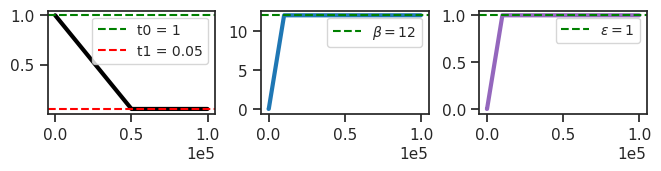

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
tr.n_iters

99840

In [7]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  402.4 K   |
|     ———      |    ———     |
|    fc_dec    |  401.4 K   |
+--------------+------------+

In [8]:
print(tr.model.layer.dec)

None

### Fit model

In [9]:
tr.train()

epoch # 160, avg loss: 17.468956: 100%|█████| 160/160 [2:08:59<00:00, 48.37s/it]


In [10]:
print(tr.model.layer.n_exp)

tensor([19, 22, 26, 30, 35, 40, 45, 50, 53, 56, 58, 60, 61, 62, 63, 64, 64, 64,
        65, 65, 65, 65, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67],
       device='cuda:2', dtype=torch.int32)

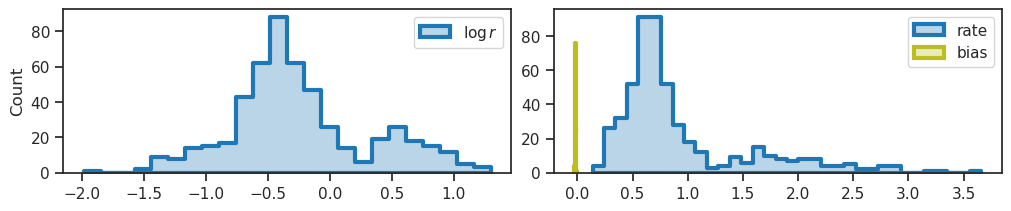

In [11]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [14]:
dead = log_rate < -1.7
dead.sum()

1

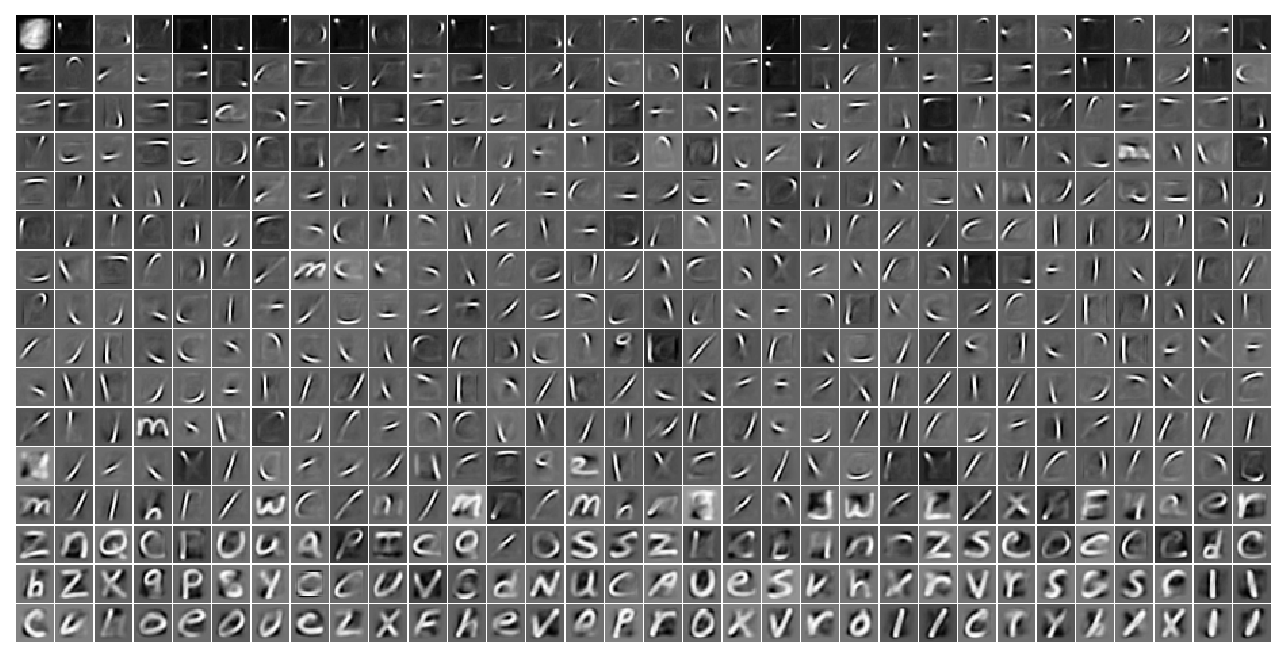

In [15]:
tr.model.show(order=np.argsort(log_rate));

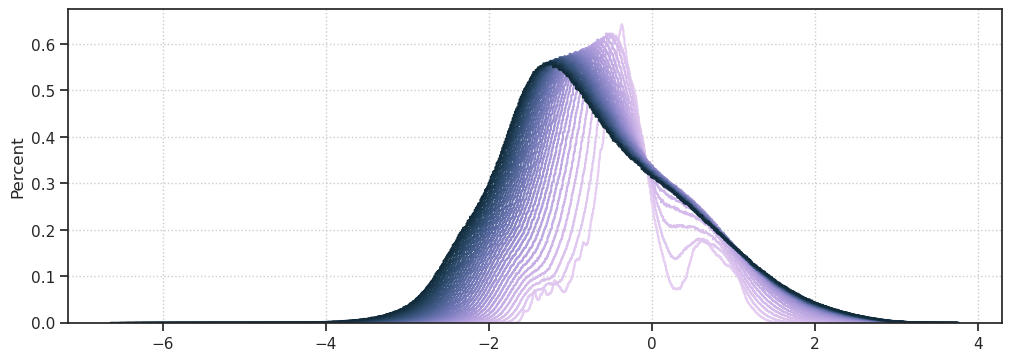

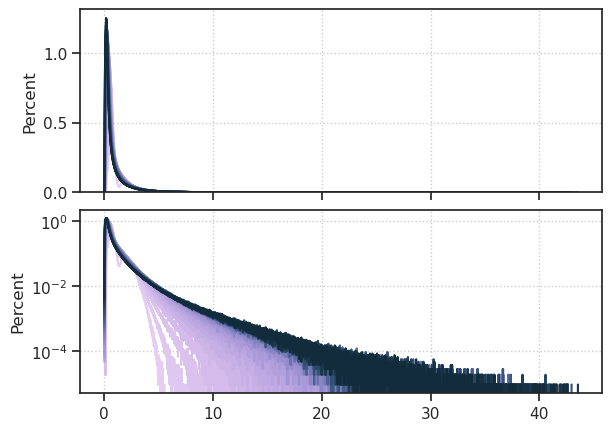

In [16]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v[:, ~dead].ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [17]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.8752970263731347, 0.7825260082915297, 0.9379240822047787],
 [0.8556294737467403, 0.7607012467427129, 0.9303698966493534],
 [0.8307588572555651, 0.7352595095847134, 0.920755401664727],
 [0.8045953480197278, 0.7106094643016453, 0.9104206137697519],
 [0.7772434076485234, 0.6867201851051512, 0.8992465126713316],
 [0.7488140989847138, 0.663555547374397, 0.8871239594805421],
 [0.7243842279061081, 0.6447757533596252, 0.8762257510361532],
 [0.6942872011488744, 0.6228296550346212, 0.8621156899688018],
 [0.6634569388588049, 0.6014800804909103, 0.8468058114666168],
 [0.6320229476966513, 0.5806736799351144, 0.8302290653034528],
 [0.6054622546457821, 0.5637088831281258, 0.8154071610911845],
 [0.5732669768785542, 0.5437477179008751, 0.796373094555329],
 [0.5408481910037145, 0.5241596982434596, 0.7759471682023664],
 [0.5083422913995962, 0.504879311294484, 0.7541087857318404],
 [0.4758855120154583, 0.4858388067481777, 0.730849789285715],
 [0.4489733517135627, 0.47010481056940817, 0.7103848289900052],
 [0.41695667742563003, 0.45132234628574797, 0.6845415010609894],
 [0.3853671819459071, 0.4325792609108464, 0.6573219220304894],
 [0.3543330369823173, 0.41380307712511316, 0.628765276150995],
 [0.32397841491559515, 0.39492111612543246, 0.5989227356460889],
 [0.29928829086417397, 0.37905306216481705, 0.573116704238121],
 [0.27048567879155966, 0.3597894788979849, 0.5410882946355793],
 [0.24268617428117248, 0.34021688339911954, 0.5079815698469353],
 [0.2159918198929715, 0.32026582325789205, 0.4738907509899629],
 [0.19465923277609198, 0.3033020135929155, 0.4448050493246117],
 [0.17023092176723864, 0.2824832211946367, 0.4091883255554043],
 [0.1471544728114009, 0.2611007271666751, 0.3729082050883482],
 [0.12550015301583156, 0.23909448773253017, 0.3360951047782604],
 [0.10532858729656207, 0.2164078749887342, 0.2988874168171155],
 [0.08968835622664696, 0.19694439287329632, 0.267684484678481],
 [0.07235872150128392, 0.17287618251766537, 0.23013648857700542]]

100%|███████████████████████████████| 104/104 [03:43<00:00,  2.15s/it]


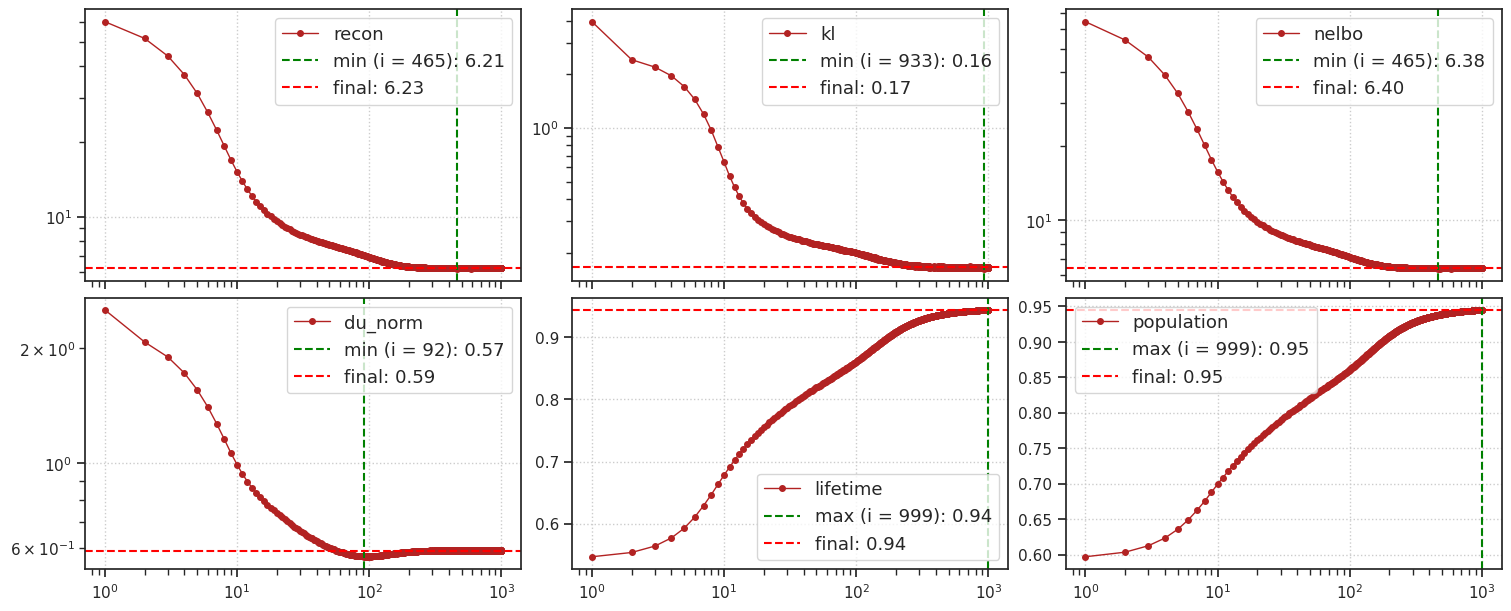

CPU times: user 3min 34s, sys: 25.7 s, total: 4min
Wall time: 4min


In [23]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(dl='vld', **kws)
_ = plot_convergence(results, color='firebrick')

## vH16:

$T = 32, \quad \beta = 32.0,$

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jacob|lin')

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = 32
cfg_tr['kl_beta'] = 32.0

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  132.1 K   |
|     ———     |    ———     |
|    layer    |  132.1 K   |
+-------------+------------+

poisson_vH16_t-32_z-[512]_<jacob|lin>
b200-ep300-lr(0.002)_beta(32:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_09_12,22:59)

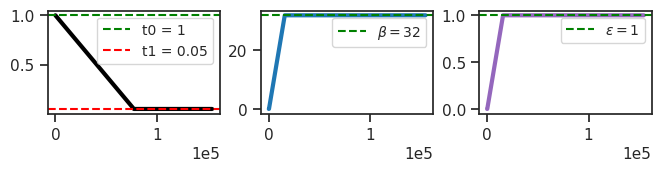

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
tr.n_iters

154500

In [7]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  132.1 K   |
|     ———      |    ———     |
|    fc_dec    |  131.1 K   |
+--------------+------------+

In [8]:
print(tr.model.layer.dec)

None

### Fit model

In [9]:
tr.train(f"u:({tr.model.cfg.clamp_u})-du:({tr.model.cfg.clamp_du})_{tr.cfg.name()}")

epoch # 300, avg loss: 59.559763: 100%|█████| 300/300 [4:43:13<00:00, 56.64s/it]


In [10]:
print(tr.model.layer.n_exp)

tensor([ 22,  31,  44,  61,  80,  99, 114, 124, 129, 133, 133, 134, 134, 134,
        134, 133, 133, 133, 133, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132], device='cuda:2', dtype=torch.int32)

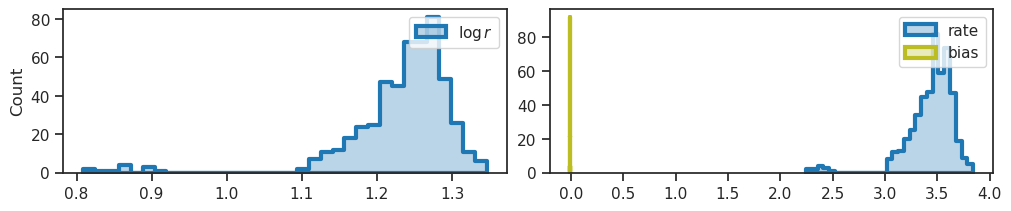

In [11]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [19]:
dead = log_rate < 1
dead.sum()

12

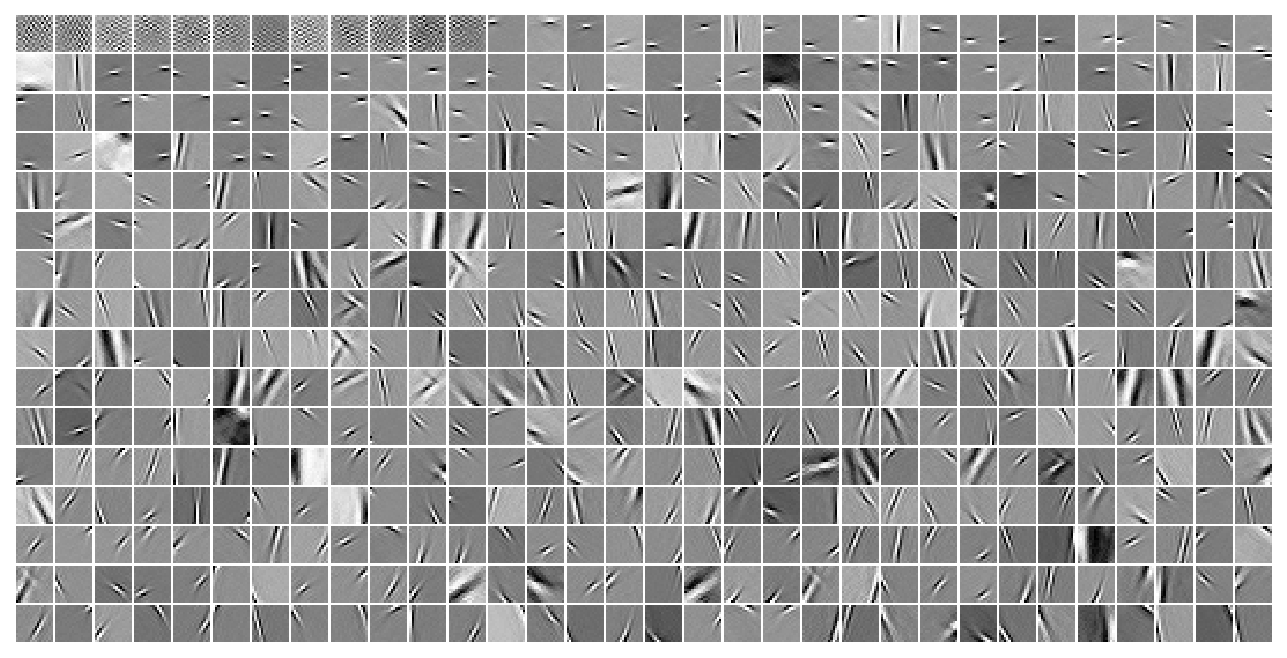

In [20]:
tr.model.show(order=np.argsort(log_rate));

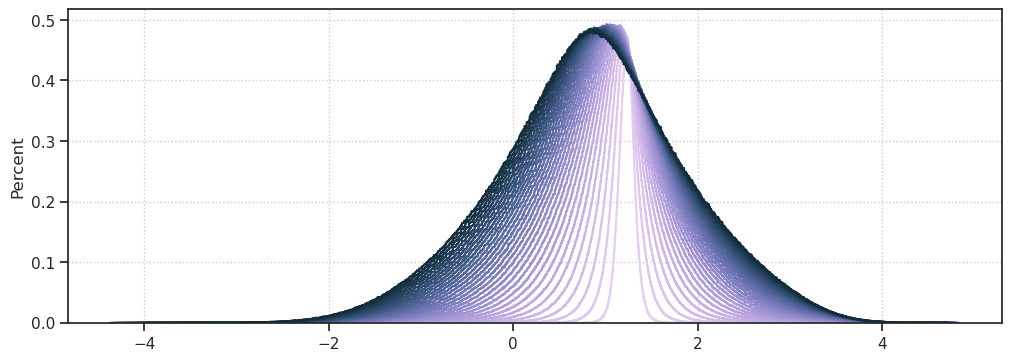

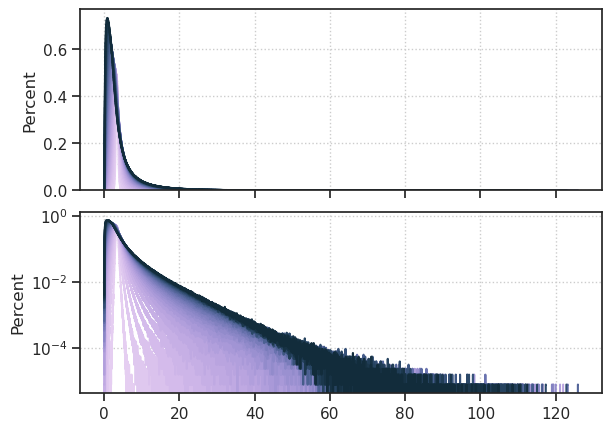

In [21]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v[:, ~dead].ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [22]:
pal

[[0.8975507056831679, 0.8094812603307622, 0.9465577040964425],
 [0.8752970263731347, 0.7825260082915297, 0.9379240822047787],
 [0.8556294737467403, 0.7607012467427129, 0.9303698966493534],
 [0.8307588572555651, 0.7352595095847134, 0.920755401664727],
 [0.8045953480197278, 0.7106094643016453, 0.9104206137697519],
 [0.7772434076485234, 0.6867201851051512, 0.8992465126713316],
 [0.7488140989847138, 0.663555547374397, 0.8871239594805421],
 [0.7243842279061081, 0.6447757533596252, 0.8762257510361532],
 [0.6942872011488744, 0.6228296550346212, 0.8621156899688018],
 [0.6634569388588049, 0.6014800804909103, 0.8468058114666168],
 [0.6320229476966513, 0.5806736799351144, 0.8302290653034528],
 [0.6054622546457821, 0.5637088831281258, 0.8154071610911845],
 [0.5732669768785542, 0.5437477179008751, 0.796373094555329],
 [0.5408481910037145, 0.5241596982434596, 0.7759471682023664],
 [0.5083422913995962, 0.504879311294484, 0.7541087857318404],
 [0.4758855120154583, 0.4858388067481777, 0.730849789285715],
 [0.4489733517135627, 0.47010481056940817, 0.7103848289900052],
 [0.41695667742563003, 0.45132234628574797, 0.6845415010609894],
 [0.3853671819459071, 0.4325792609108464, 0.6573219220304894],
 [0.3543330369823173, 0.41380307712511316, 0.628765276150995],
 [0.32397841491559515, 0.39492111612543246, 0.5989227356460889],
 [0.29928829086417397, 0.37905306216481705, 0.573116704238121],
 [0.27048567879155966, 0.3597894788979849, 0.5410882946355793],
 [0.24268617428117248, 0.34021688339911954, 0.5079815698469353],
 [0.2159918198929715, 0.32026582325789205, 0.4738907509899629],
 [0.19465923277609198, 0.3033020135929155, 0.4448050493246117],
 [0.17023092176723864, 0.2824832211946367, 0.4091883255554043],
 [0.1471544728114009, 0.2611007271666751, 0.3729082050883482],
 [0.12550015301583156, 0.23909448773253017, 0.3360951047782604],
 [0.10532858729656207, 0.2164078749887342, 0.2988874168171155],
 [0.08968835622664696, 0.19694439287329632, 0.267684484678481],
 [0.07235872150128392, 0.17287618251766537, 0.23013648857700542]]

100%|███████████████████████████████| 130/130 [09:38<00:00,  4.45s/it]


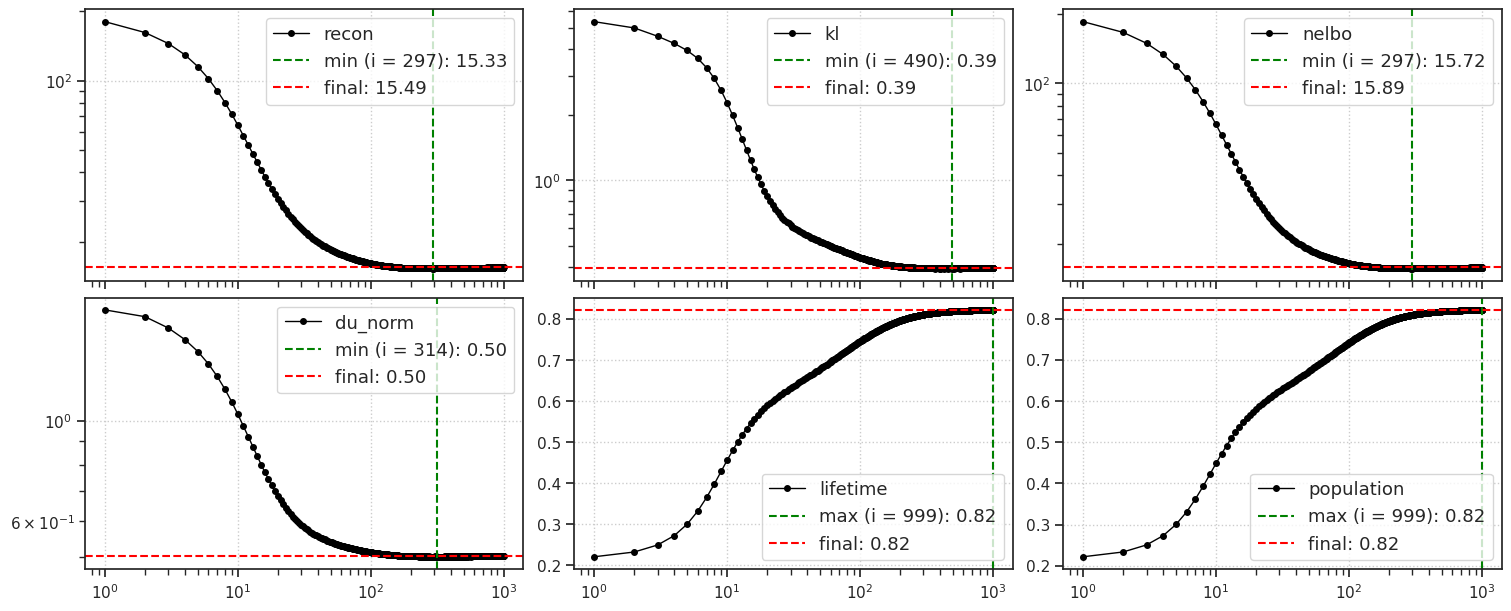

CPU times: user 9min 27s, sys: 26.9 s, total: 9min 54s
Wall time: 9min 54s


In [23]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(dl_name='vld', **kws)
_ = plot_convergence(results, color='k')

100%|███████████████████████████████| 130/130 [09:41<00:00,  4.47s/it]


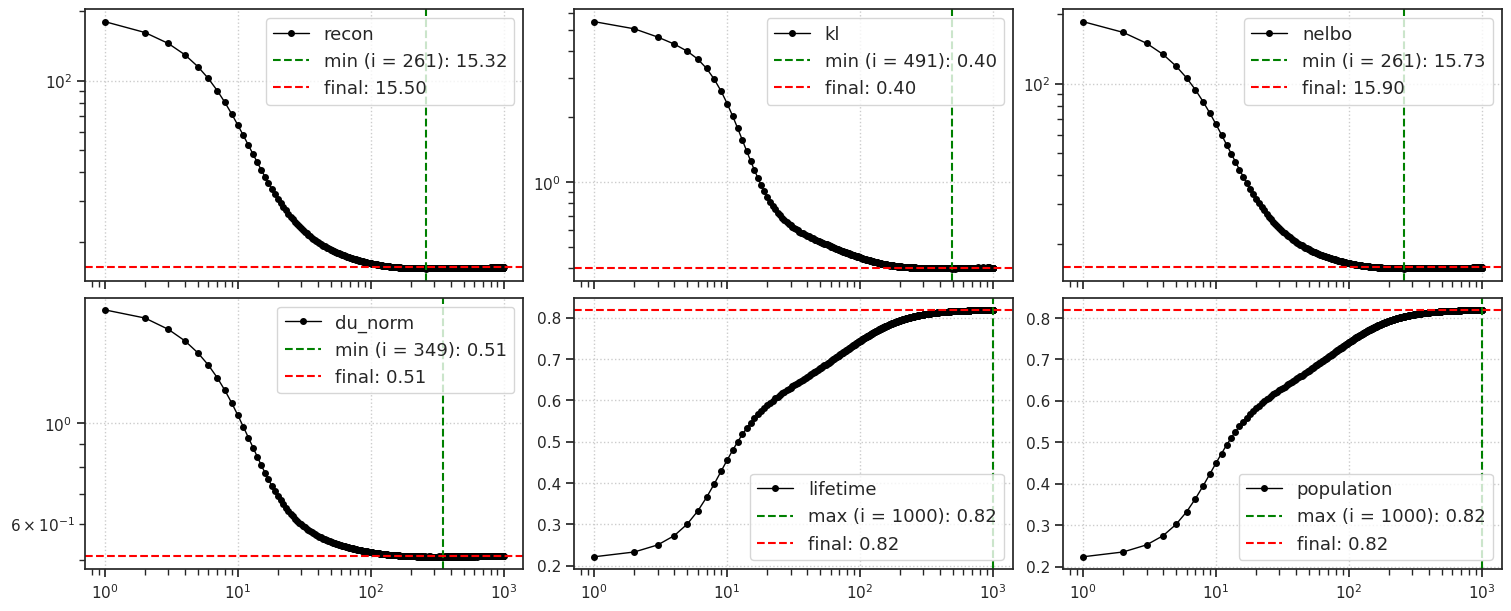

CPU times: user 9min 29s, sys: 27.5 s, total: 9min 57s
Wall time: 9min 56s


In [25]:
def fit_norm(data):
    rv = sp_stats.norm(*sp_stats.norm.fit(data))
    ks_test = sp_stats.kstest(
        rvs=data,
        cdf='norm',
        args=(rv.mean(), rv.std()),
    )
    return rv, ks_test


def fit_t(data):
    df, loc, scale = sp_stats.t.fit(data)
    rv = sp_stats.t(df, loc, scale)
    ks_test = sp_stats.kstest(
        rvs=data,
        cdf='t',
        args=(df, loc, scale),
    )
    return rv, ks_test

100%|███████████████████████████████████████████| 32/32 [03:38<00:00,  6.83s/it]


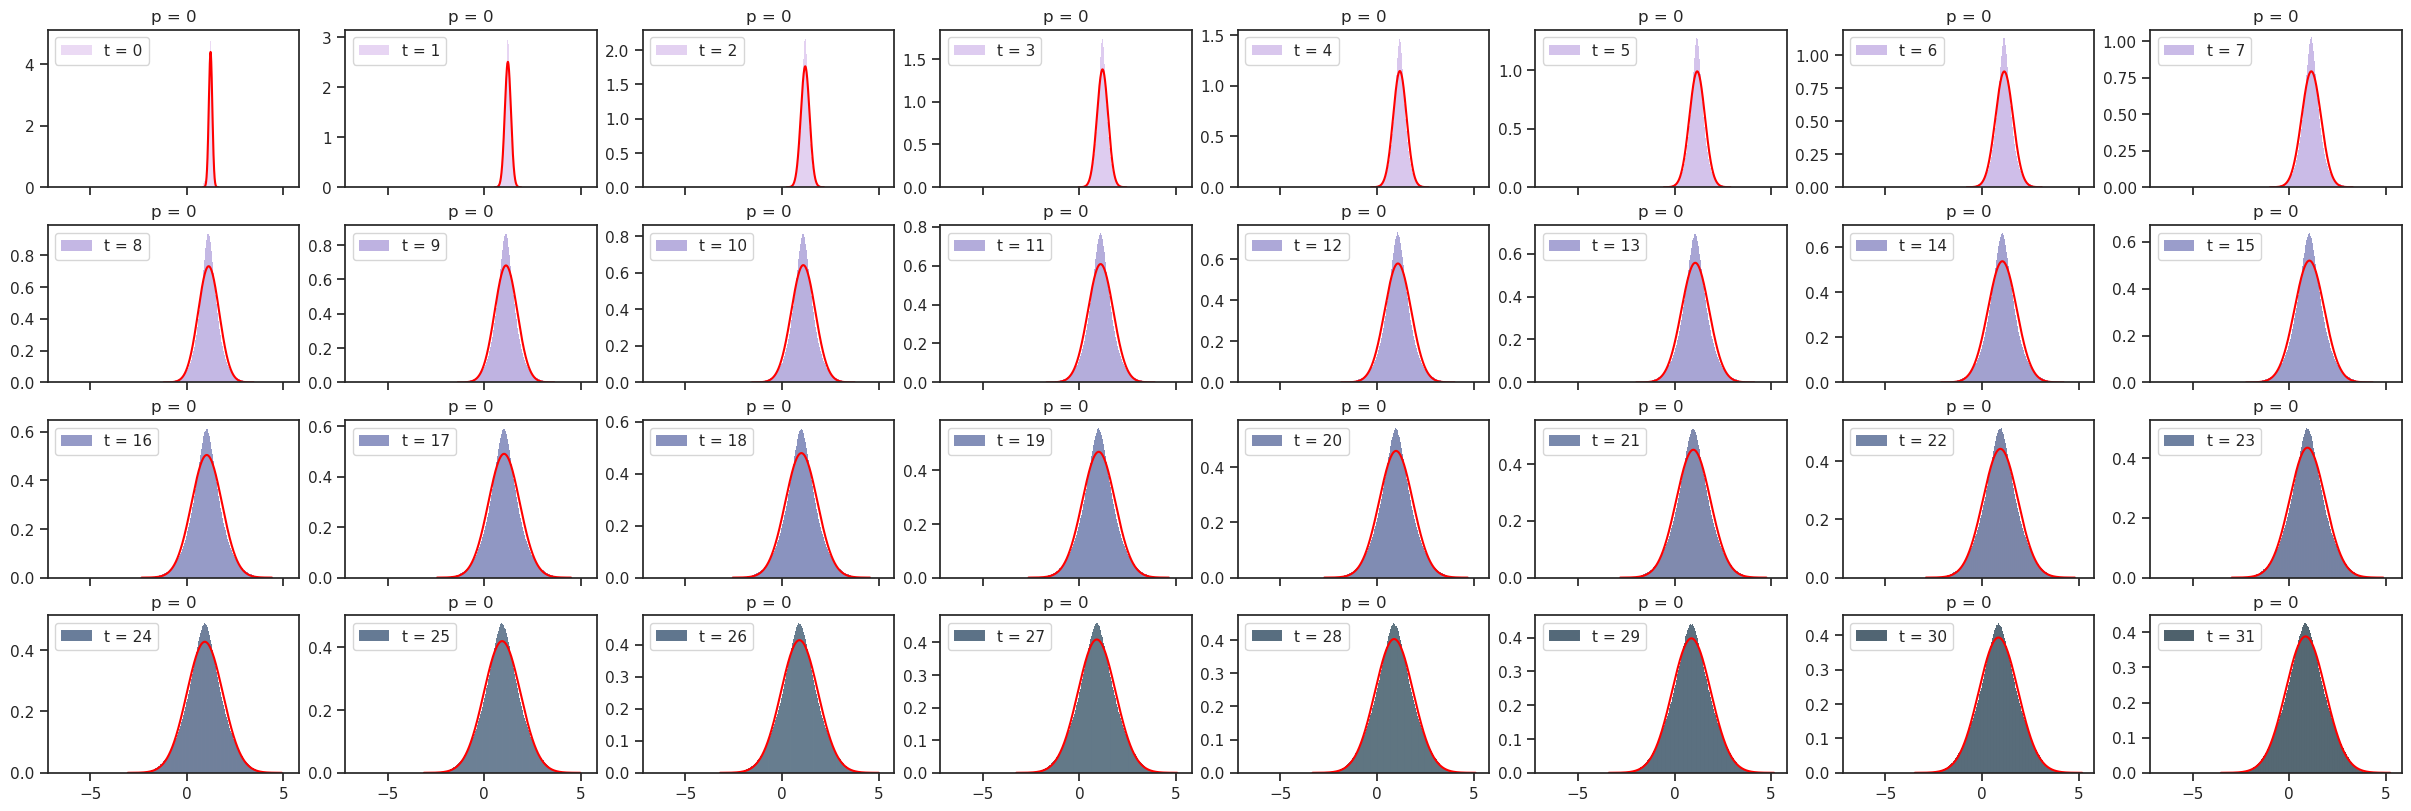

In [24]:
nrows = 4
ncols = int(np.ceil(len(posterior_log_rates) / nrows))
fig, axes = create_figure(nrows, ncols, sharex='all')
for t, data in tqdm(posterior_log_rates.items()):
    rv, ks_test = fit_norm(data[:, ~dead].ravel())
    xs = np.linspace(
        start=rv.ppf(1e-5),
        stop=rv.ppf(1 - 1e-5),
        num=10000,
    )
    pdf = rv.pdf(xs)

    i = int(t)
    ax = axes.flat[i]
    sns.histplot(data.ravel(), stat='density', color=pal[i], label=f"t = {t}", ax=ax)
    ax.plot(xs, pdf, color='r')
    ax.set(title=f"p = {ks_test.pvalue:0.2g}", ylabel='')
add_legend(axes)
plt.show()

In [ ]:
nrows = 4
ncols = int(np.ceil(len(posterior_log_rates) / nrows))
fig, axes = create_figure(nrows, ncols, sharex='all')
for t, data in tqdm(posterior_log_rates.items()):
    rv, ks_test = fit_t(data[:, ~dead].ravel())
    xs = np.linspace(
        start=rv.ppf(1e-5),
        stop=rv.ppf(1 - 1e-5),
        num=10000,
    )
    pdf = rv.pdf(xs)

    i = int(t)
    ax = axes.flat[i]
    sns.histplot(data.ravel(), stat='density', color=pal[i], label=f"t = {t}", ax=ax)
    ax.plot(xs, pdf, color='r')
    ax.set(title=f"p = {ks_test.pvalue:0.2g}", ylabel='')
add_legend(axes)
plt.show()

 22%|████████▉                                | 7/32 [48:00<2:42:52, 390.89s/it]

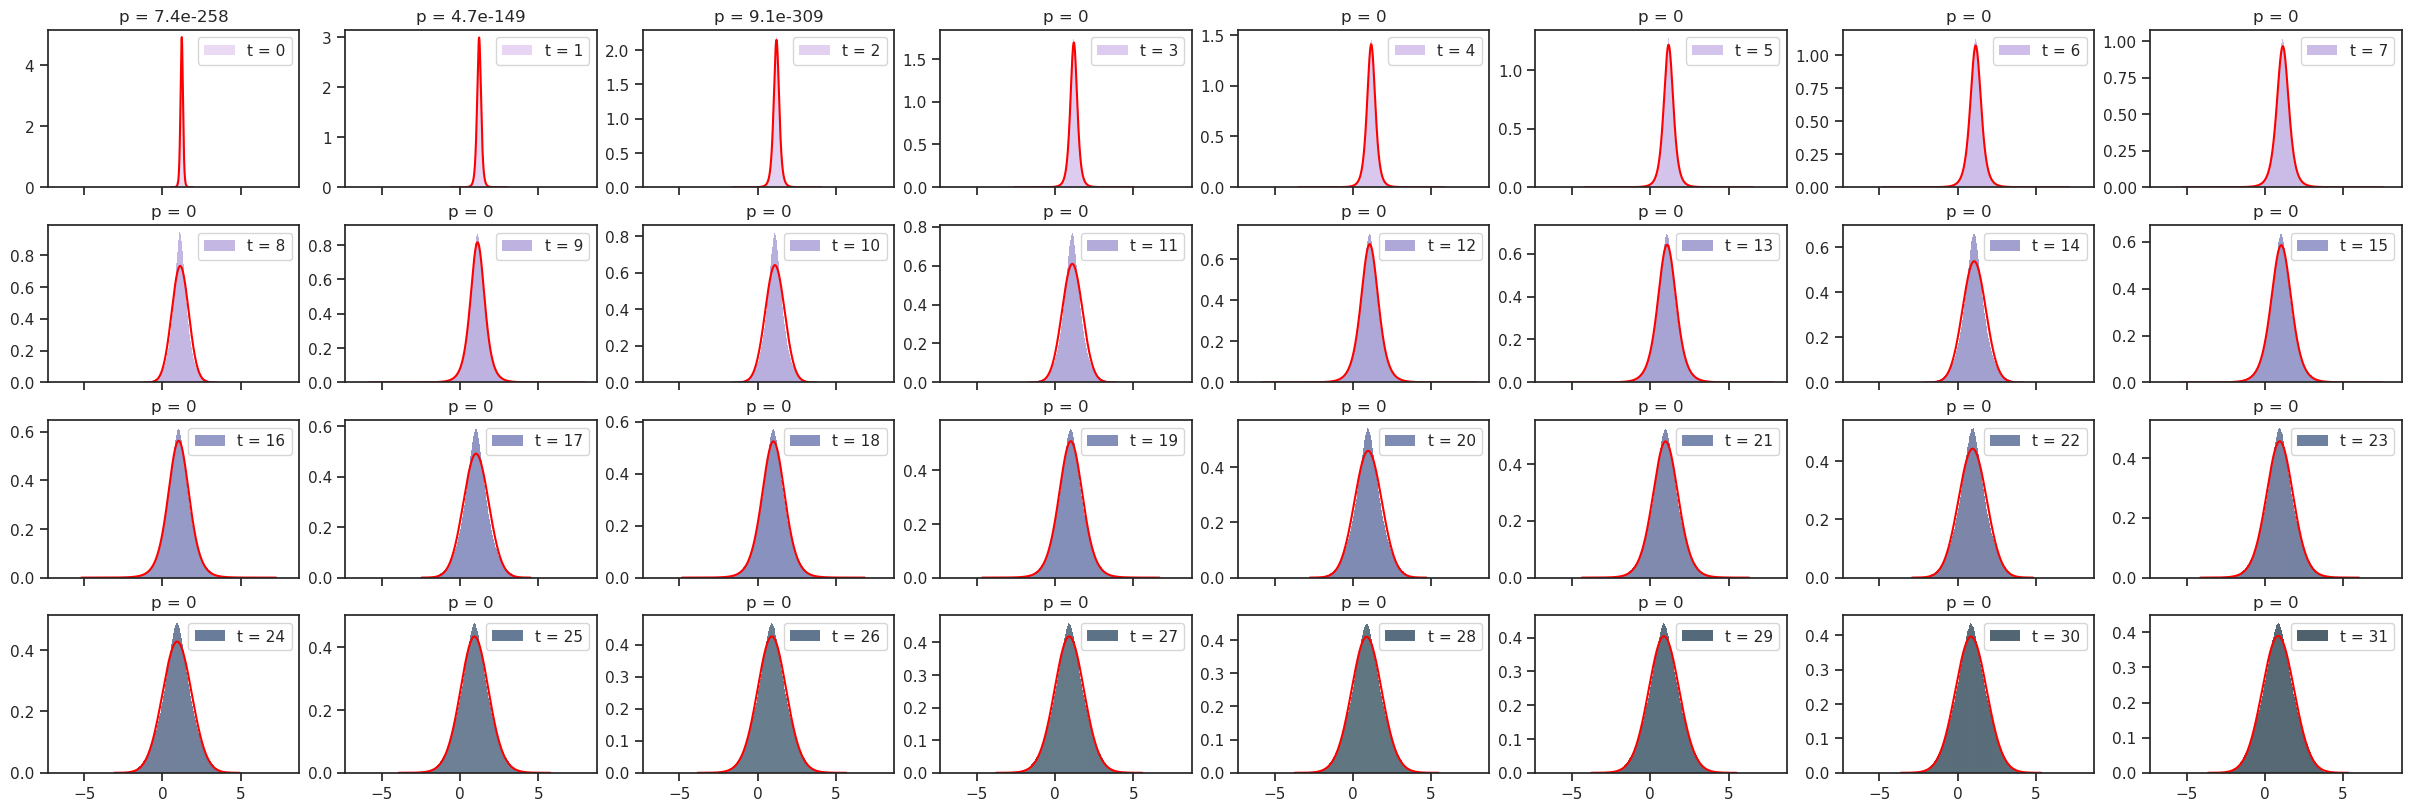

In [28]:
fig

## MNIST GAUS:

A gaussian reproduction attempt of gold standard is running on ```ch```. Here, I only changed kl_adjuster to linear. Will it help?

<Axes: ylabel='Count'>

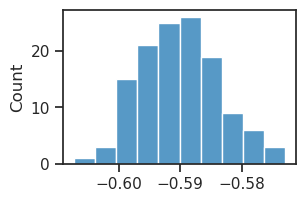

In [12]:
# loc = tonp(tr.model.layer.loc).ravel()
# log_scale = tonp(tr.model.layer.log_scale).ravel()
# bias = tonp(tr.model.layer.bias).ravel()

# sns.histplot(log_scale)

# # loc, log_scale, bias

In [13]:
# dead = log_scale > 1.0
# dead.sum()

0

In [16]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld']
}

100%|█████████████████████████████████| 50/50 [03:46<00:00,  4.54s/it]


CPU times: user 3min 44s, sys: 3.69 s, total: 3min 48s
Wall time: 3min 48s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

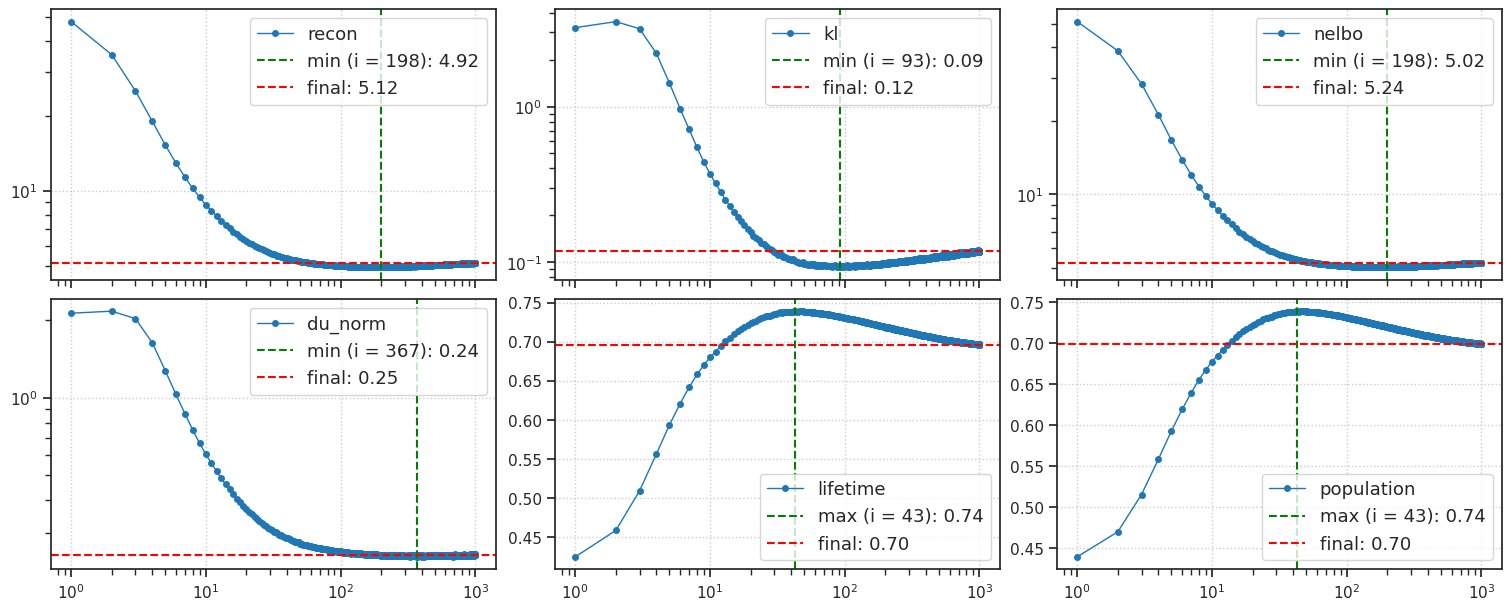

In [17]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

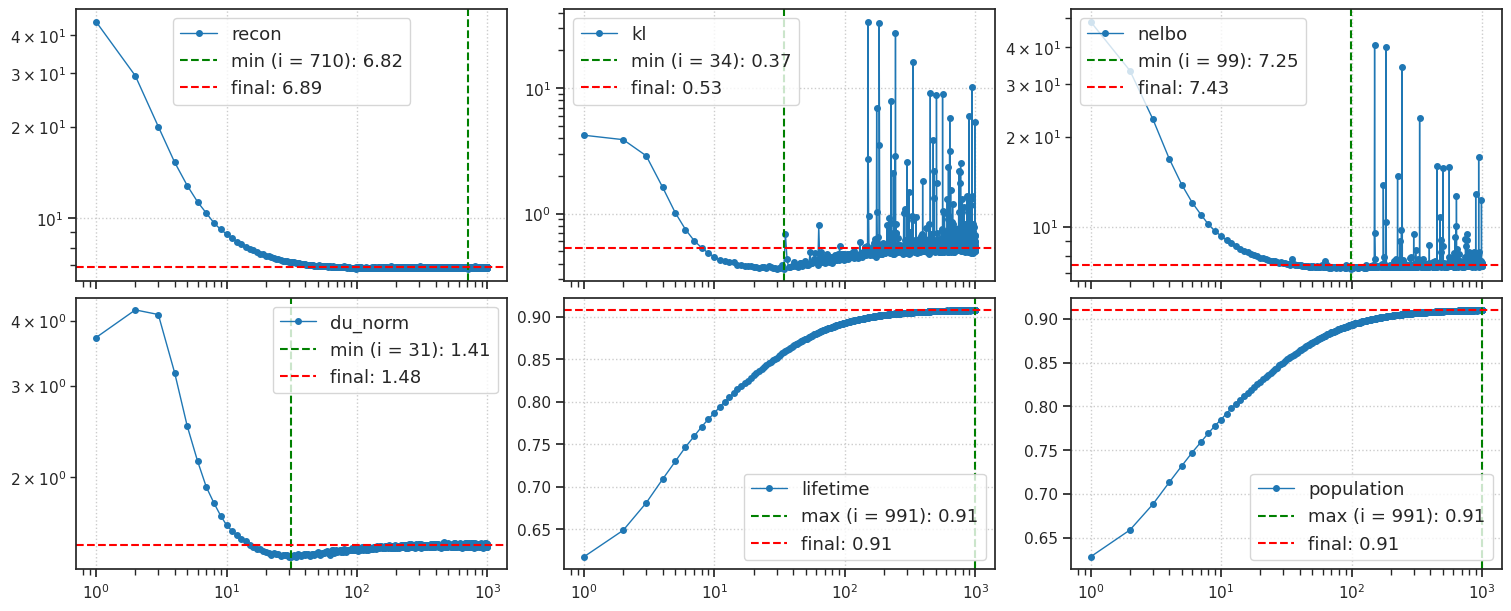

In [14]:
%%time

kws = dict(
    seq_total=tr.model.cfg.seq_len,
    seq_batch_sz=100,
    n_data_batches=1,
    active=~dead,
    full_data=True,
    return_recon=True,
)
results_to_plot = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['trn', 'vld'] # , 'tst']
}

100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.86it/s]


CPU times: user 14.2 s, sys: 639 ms, total: 14.9 s
Wall time: 435 ms


In [22]:
num = 32

for name, d in results_to_plot.items():
    print('_' * 110)
    print('-' * 110)
    print(name)
    
    x2p = np.concatenate([
        d['x'][:num],
        d['y'][:num, -1].reshape(-1, *tr.model.cfg.input_sz),
    ])
    x2p = (x2p + 1) / 2
    # _ = plot_weights(x2p, nrows=2)

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

trn

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

In [23]:
x2p.shape

(64, 3, 32, 32)

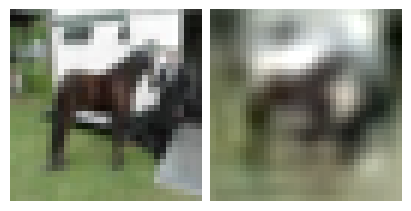

In [42]:
fig, axes = create_figure(1, 2, (4, 2))
axes[0].imshow(x2p[20].transpose(1, 2, 0))
axes[1].imshow(x2p[20+32].transpose(1, 2, 0))
remove_ticks(axes)
plt.show()

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 24.19it/s]


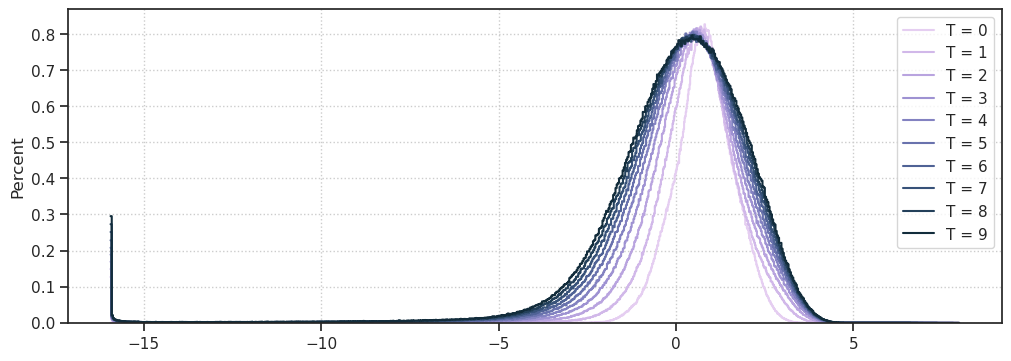

In [43]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in tqdm(iter(tr.dl_vld)):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


pal = sns.cubehelix_palette(
    n_colors=tr.model.cfg.seq_len,
    start=2.5,
    rot=0.3,
    gamma=1.0,
    hue=0.9,
    light=0.85,
    dark=0.15,
    reverse=False,
    as_cmap=False,
)


fig, ax = create_figure(1, 1, (10, 3.5))
for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v.ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
ax.legend()
ax.grid()
plt.show()

### Generate

In [17]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

output = tr.model.generate(pred, seq=range(300))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['ff', 'dist', 'samples', 'recon', 'loss_kl', 'loss_recon']

In [18]:
shape = (tr.model.cfg.input_sz, tr.model.cfg.input_sz)

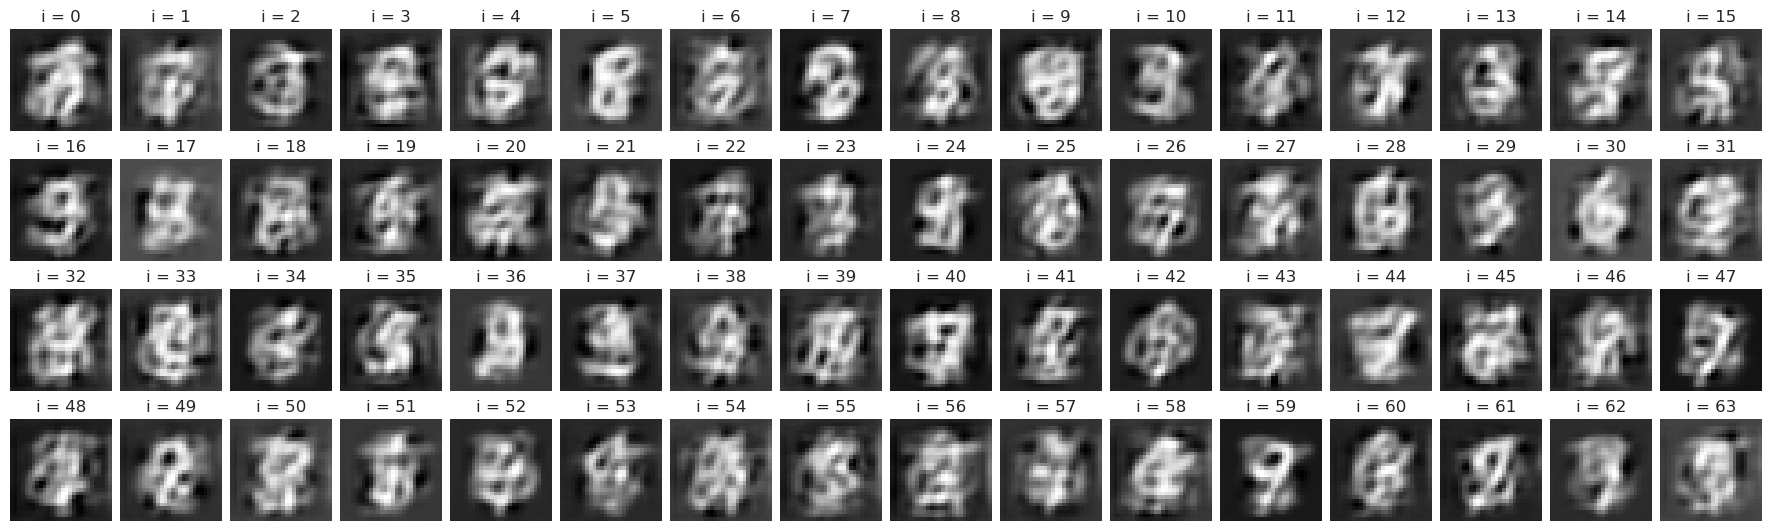

In [19]:
nrows = 4
ncols = int(np.ceil(n_samples / nrows))
fig, axes = create_figure(nrows, ncols, (1.1 * ncols, 1.3 * nrows), 'all', 'all')
for sample_i, ax in enumerate(axes.flat):
    i, j = sample_i // ncols, sample_i % ncols
    x2p = tonp(pred[sample_i].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
    ax.set_title(f"i = {sample_i}")
trim_axs(axes, len(pred))
remove_ticks(axes)
plt.show()

In [21]:
sample_i = 32

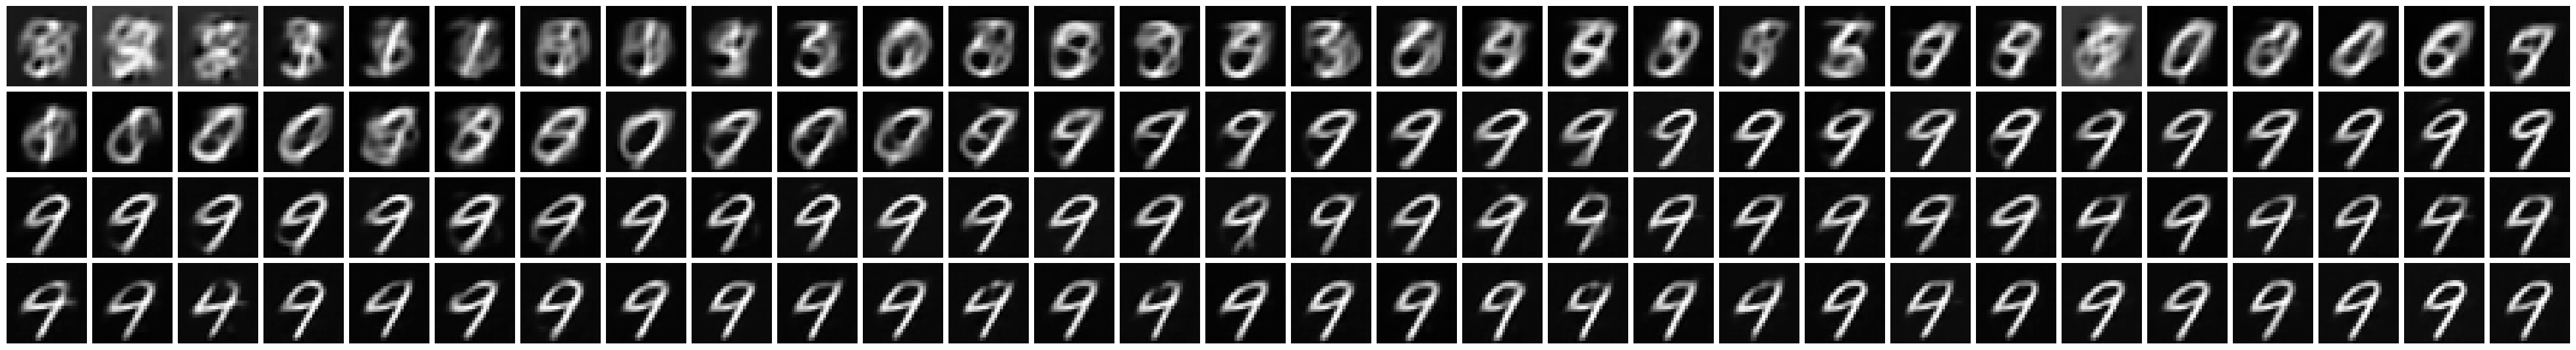

In [22]:
nrows, ncols = 4, 30
fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all')
for idx, ax in enumerate(axes.flat):
    i, j = idx // ncols, idx % ncols
    x2p = tonp(output['recon'][sample_i, idx].reshape(shape))
    ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes)

In [25]:
order = np.argsort(desc_len)[::-1]

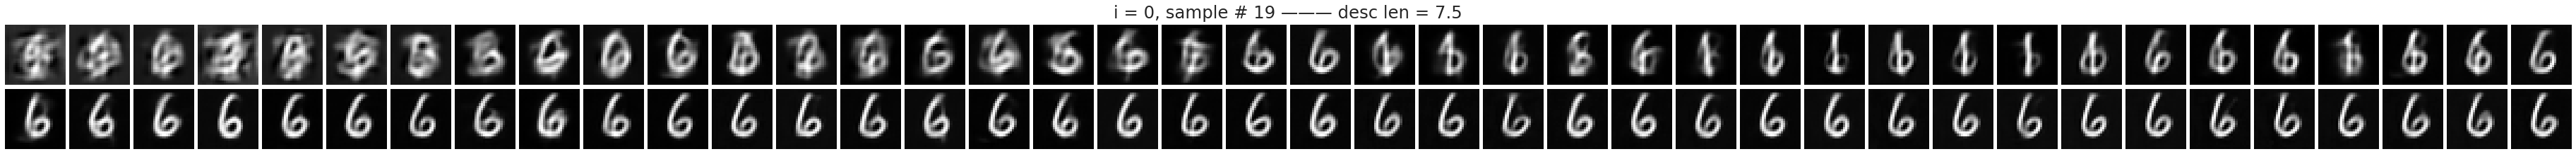

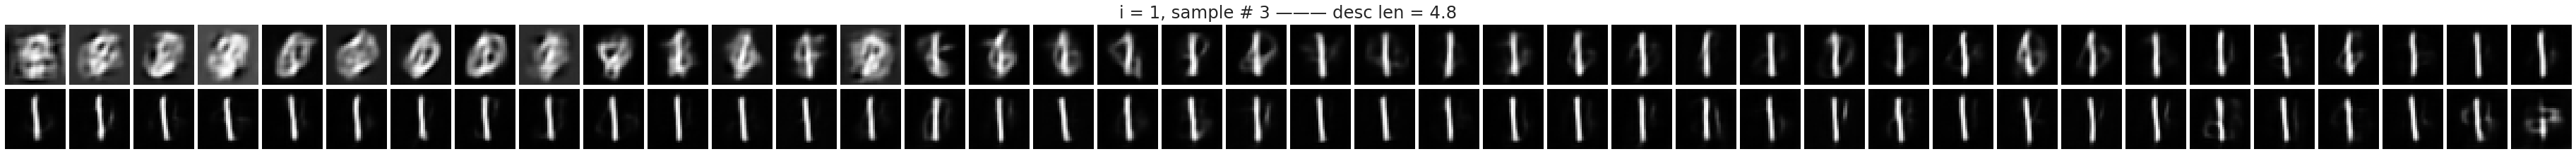

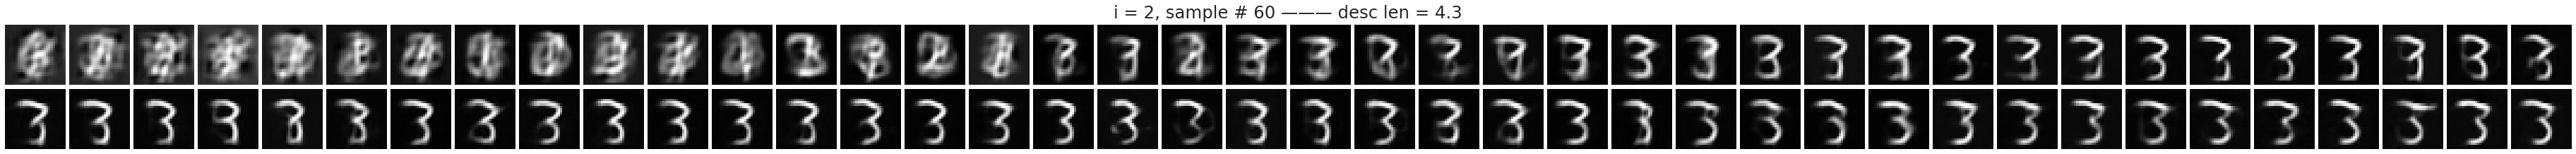

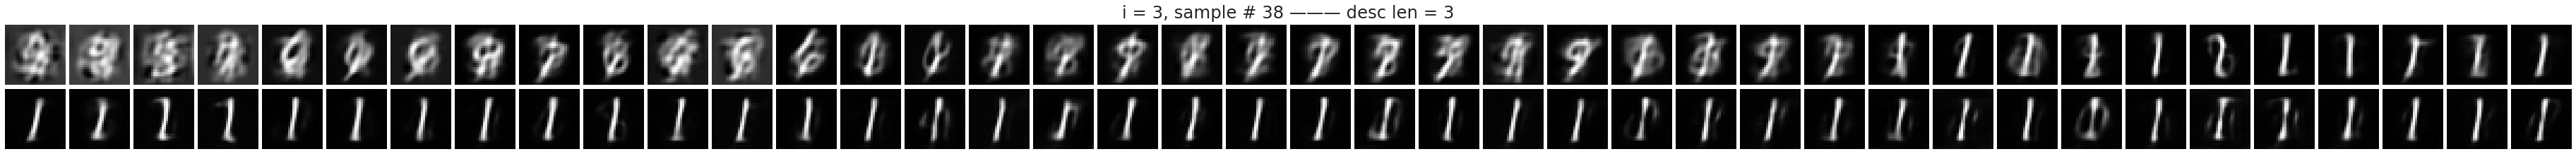

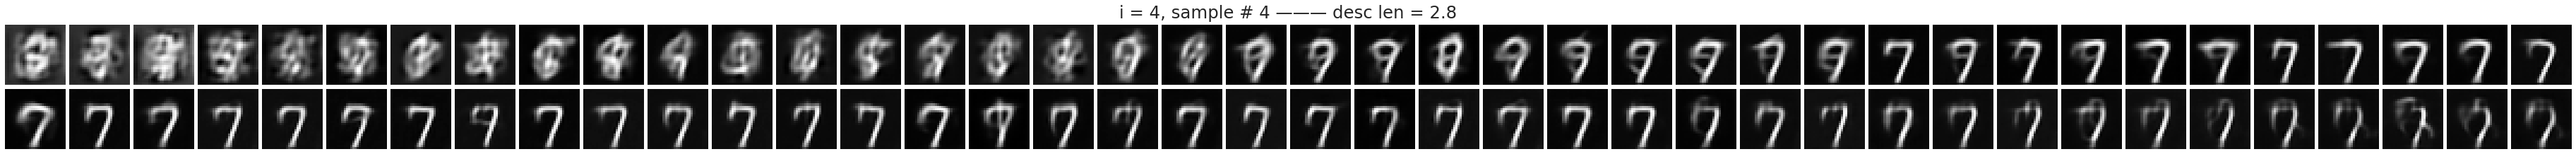

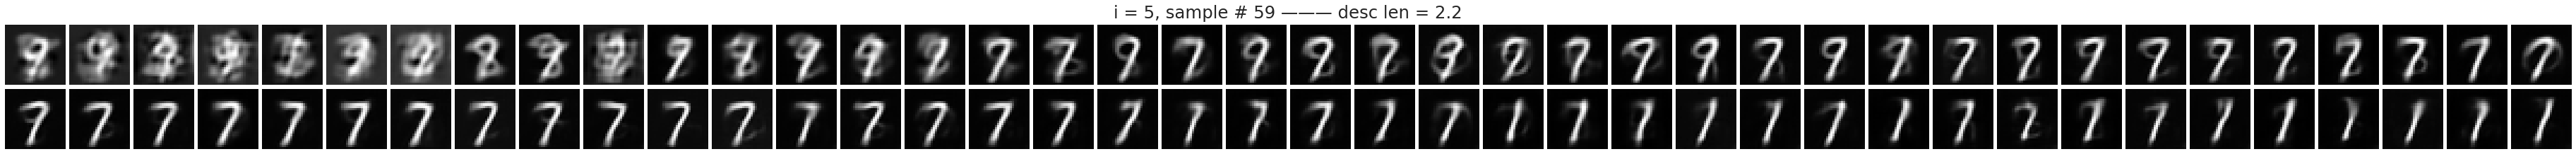

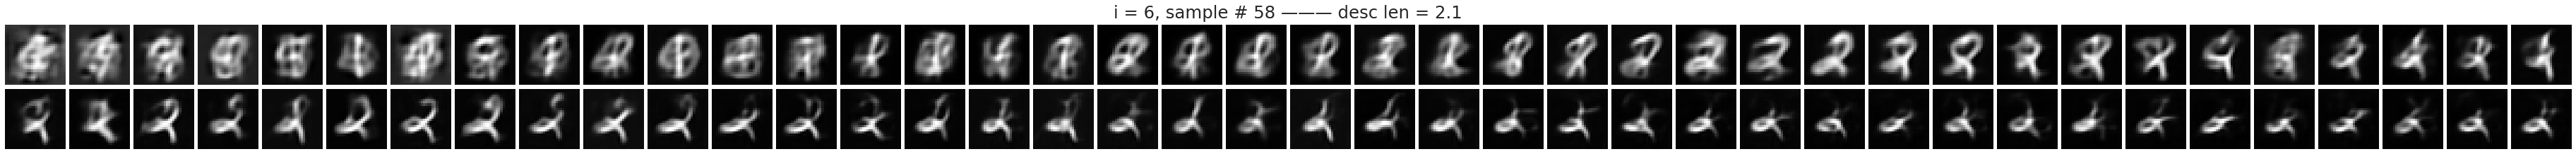

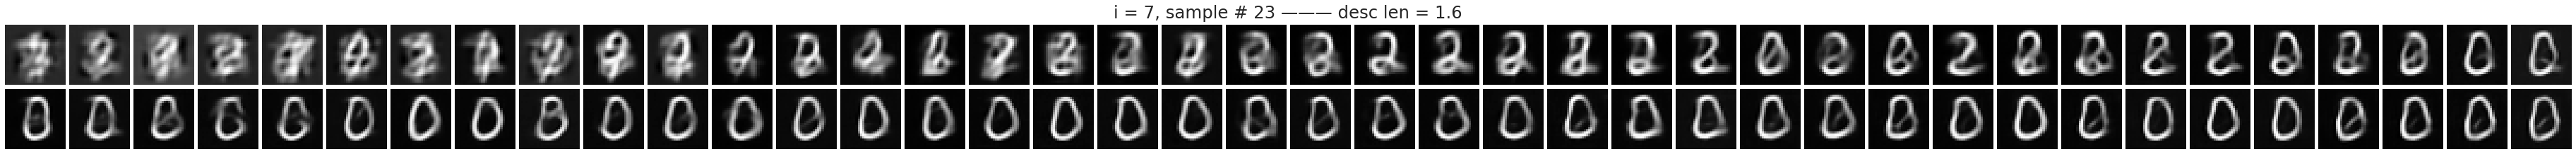

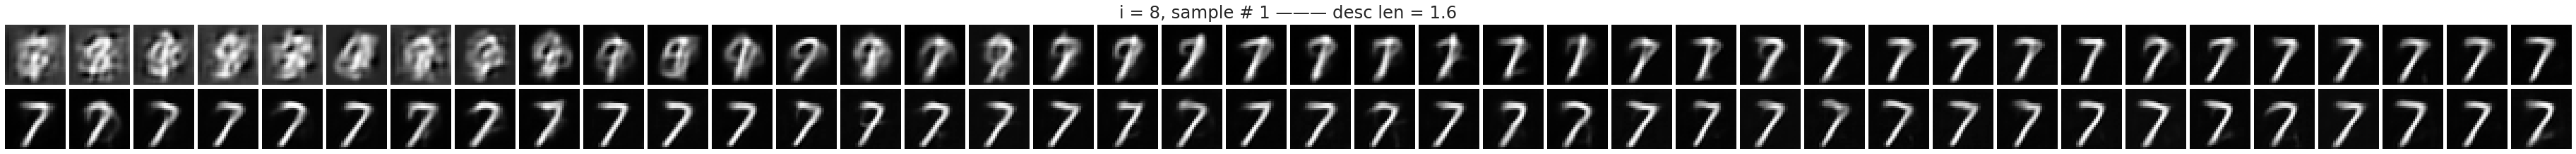

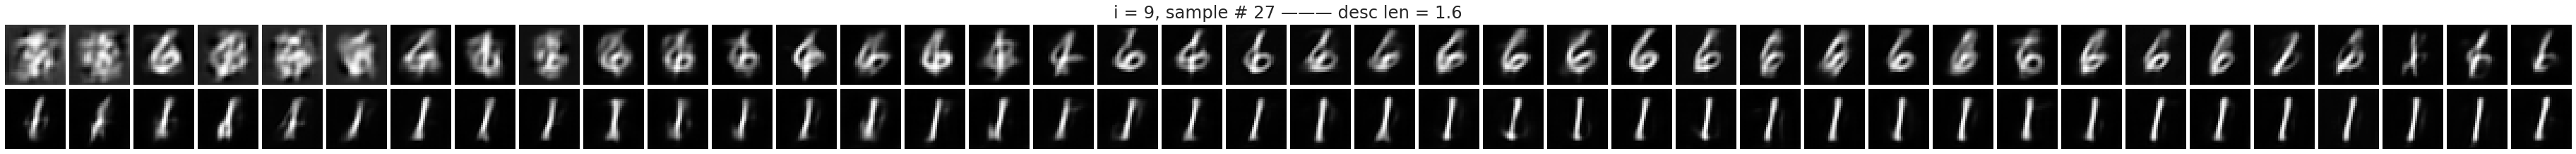

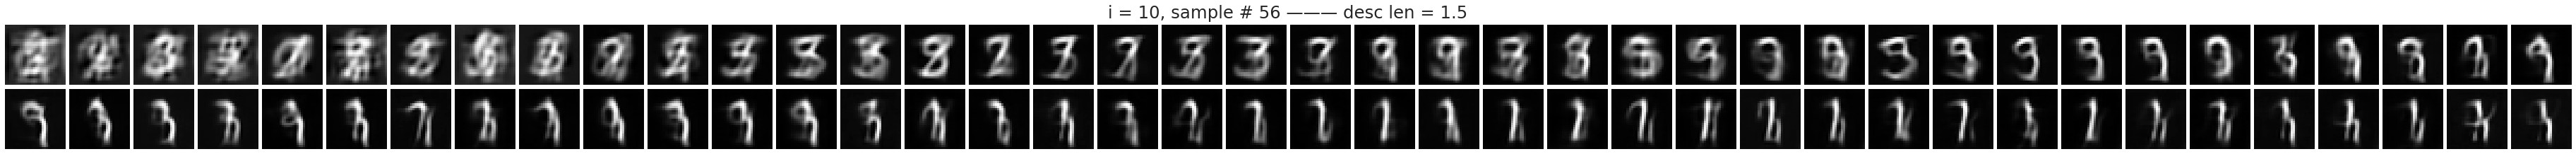

In [26]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 2, 40
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=70)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i].reshape(shape))
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(output['recon'][sample_i, idx - 1].reshape(28, 28))
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()